# US Name
Estimate kandhelwal_quality as a function of  ln_lag_tax_rebate and others variables


# Description

- Change sign for story
- Check sign price adjusted
- Estimate table 1
- Estimate table 2
- Estimate table 4
- Estimate table 5

## Variables
### Target

kandhelwal_quality

### Features

- ln_lag_tax_rebate
- regime
- ln_lag_import_tax

## Complementary information



# Metadata

- Key: 198_VAT_rebate_quality
- Epic: Models
- US: Baseline table
- Task tag: #data-analysis
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name**

- china_vat_quality

**Github**

- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/04_baseline_vat_quantity_covariates.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [5]:
change_target <- function(table){
    ## Regime
    check_target <- grep("regimeELIGIBLE:ln_lag_import_tax", rownames(table$coef))
    
    if (length(check_target) !=0) {
    ## SOE
    rownames(table$coefficients)[check_target] <- 'ln_lag_import_tax:regimeELIGIBLE'
    rownames(table$beta)[check_target] <- 'ln_lag_import_tax:regimeELIGIBLE'
    } 
    return (table)
}

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [6]:
db = 'chinese_trade'
table = 'china_vat_quality'

In [7]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [8]:
download_data = False
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
    except:
        pass
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)

In [9]:
pd.DataFrame(schema)

,Name,Type,Comment
0,geocode4_corr,string,city name
1,year,string,year
2,regime,varchar(12),eligible or no eligible to vat rebate
3,hs6,string,HS6 6 digit
4,hs4,string,HS4 4 digit
5,hs3,string,HS3 3 digit
6,hs2,string,HS2 2 digit
7,homogeneous,string,Goods label
8,country_en,string,English country name
9,iso_alpha,string,


# compute fixed effect

| Benchmark | Origin            | Name                     | Description                                                                                                                                                                                                                                                                                                                                    | Math_notebook     |
|-----------|-------------------|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------|
| Yes       | Current           | city-product             |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}$     |
| Yes       | Current           | city-product-regime      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}^R$   |
| Yes       | Current           | city-sector-year         | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}$    |
| Yes       | Current           | city-sectorーregime-year | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}^R$  |
| Yes       | Current           | product-destination      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{pj}$     |
| Yes       | Previous baseline | Product-year             | account for all factors that affect product-level export irrespective of the trade regime in a given year                                                                                                                                                                                                                                      | $\alpha_{pt}$     |
| No        | Previous baseline | firm-product-eligibility | captures all the factors that affect firms regardless of the time and type of regime. This firm‒product pair eliminates the demand shocks that firms face and that are not correlated with the types of status. The fixed effects are also responsible for potential correlations between subsidies, R&D, or trade policies and VAT rebates.   | $\alpha^{E}_{it}$ |
| No        | Previous baseline | HS4-year-eligibility     |                                                                                                                                                                                                                                                                                                                                                | $\alpha^{E}_{st}$ |
| No        | Previous baseline | city-year                | captures the differences in demand, capital intensity, or labor supply that prevail between cities each year                                                                                                                                                                                                                                   | $\alpha_{ct}$     |
| No        | Candidate         | destination-year         | Captures additional level of control, encompassing all the shocks and developments in the economies to which China exports.                                                                                                                                                                                                                    | $\alpha_{dt}$     |


Create the following fixed effect for the baseline regression:

**index**

* city: `c`
* product: `k`
* sector: `s`
* year: `t`
* Destination: `j`
* regime: `r`

**FE**

* city-product: `FE_ck`
* City-sector-year: `FE_cst`
* City-product-regime: `FE_ckr`
* City-sector-regime-year: `FE_csrt`
* Product-year: `FE_kt`
* Product-destination: `FE_pj`
* Destination-year: `FE_jt`

<!-- #endregion -->

In [10]:
create_fe = False
if create_fe:
    df = pd.read_csv(df_path, dtype = dtypes)
    ### city-product
    df["fe_ck"] = pd.factorize(df["geocode4_corr"].astype('str') + 
                                        df["hs6"].astype('str')
                                       )[0]
    
    ### sector-year
    df["fe_st"] = pd.factorize(
                                        df["hs4"].astype('str') +
                                        df["year"].astype('str')
                                       )[0]

    ### sector-year
    df["fe_ct"] = pd.factorize(
                                        df["geocode4_corr"].astype('str') +
                                        df["year"].astype('str')
                                       )[0]
    
    ### City-sector-year
    df["fe_cst"] = pd.factorize(df["geocode4_corr"].astype('str') + 
                                        df["hs4"].astype('str') +
                                        df["year"].astype('str')
                                       )[0]

    ### City-product-regime
    df["fe_ckr"] = pd.factorize(df["geocode4_corr"].astype('str') + 
                                        df["hs6"].astype('str') +
                                        df["regime"].astype('str')
                                       )[0]

    ### City-sector-regime-year
    df["fe_csrt"] = pd.factorize(df["geocode4_corr"].astype('str') + 
                                        df["hs4"].astype('str') +
                                        df["regime"].astype('str') +
                                        df["year"].astype('str')
                                       )[0]

    ## Product-year
    df["fe_kt"] = pd.factorize(df["hs6"].astype('str') + 
                                        df["year"].astype('str')
                                       )[0]

    ## Product-destination
    df["fe_kj"] = pd.factorize(df["hs6"].astype('str') + 
                                        df["country_en"].astype('str')
                                       )[0]

    ## Destination-year
    df["fe_jt"] = pd.factorize(df["country_en"].astype('str') + 
                                        df["year"].astype('str')
                                       )[0]
    
    ## Destination-year-regime
    df["fe_jtr"] = pd.factorize(df["country_en"].astype('str') + 
                                        df["year"].astype('str') +
                                df["regime"].astype('str')
                                
                                       )[0]

    ## city-product-destination
    df["fe_ckj"] = pd.factorize(df["geocode4_corr"].astype('str') + 
                                        df["hs6"].astype('str') + 
                                        df["country_en"].astype('str')
                                       )[0]
    
    ## product destination regime 
    df["fe_kjr"] = pd.factorize(df["hs6"].astype('str') + 
                                        df["country_en"].astype('str') + 
                                        df["regime"].astype('str')
                                       )[0]
    ## Shocks
    df["fe_group_shock"] = pd.factorize(
        df["hs6"].astype('str') +
        df["country_en"].astype('str') + 
        df["year"].astype('str'))[0]
    
    df.to_csv(os.path.join(path_local, filename + '.csv'), index = False)

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [11]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        {
        'old':'ln\_lag\_tax\_rebate',
        'new':'\\text{Ln VAT export tax}_{k, t-1}'
        },
        {
        'old':'ln\_rebate',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'ln\_rebate\_1',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'ln\_rebate\_2',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'regimeELIGIBLE',
        'new':'\\text{Regime}^R'
        },
        {
        'old':'ln\_lag\_import\_tax',
        'new':'\\text{Ln VAT import tax,}_{k, t-1}'
        },
        {
        'old':'lag\_foreign\_export\_share\_ckr',
        'new':'\\text{lag foreign export share}_{ck, t-1}^R'
        },
        {
        'old':'lag\_soe\_export\_share\_ckr',
        'new':'\\text{lag SOE export share}_{ck, t-1}^R'
        }
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [12]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [13]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [14]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    regime = relevel(as.factor(regime), ref='NOT_ELIGIBLE'),
    ln_rebate = ln_lag_tax_rebate * (-1),
    ln_rebate_1 = log((lag_vat_reb_m / lag_vat_m) +1),
    ln_rebate_2 = log(lag_vat_reb_m + 1)
      )

Parsed with column specification:
cols(
  .default = col_double(),
  regime = col_character(),
  homogeneous = col_character(),
  country_en = col_character(),
  iso_alpha = col_character(),
  income_group = col_character(),
  income_group_ldc_dc = col_character(),
  high_tech = col_character(),
  energy = col_character(),
  skilled = col_logical(),
  rd_oriented = col_logical(),
  size_quantity = col_character(),
  size_product = col_character()
)
See spec(...) for full column specifications.


In [15]:
head(df_final)

geocode4_corr,year,regime,hs6,hs4,hs3,hs2,homogeneous,country_en,iso_alpha,...,fe_jt,fe_ckj,fe_group_shock,fe_kjr,fe_st,fe_ct,fe_jtr,ln_rebate,ln_rebate_1,ln_rebate_2
5103,2004,ELIGIBLE,810210,8102,810,81,HOMOGENEOUS,Netherlands,NLD,...,0,0,0,0,0,0,0,-1.609438,0.5679840,2.639057
5103,2004,ELIGIBLE,810295,8102,810,81,HETEREGENEOUS,Netherlands,NLD,...,0,1,1,1,0,0,0,-1.609438,0.5679840,2.639057
5103,2006,ELIGIBLE,810210,8102,810,81,HOMOGENEOUS,Netherlands,NLD,...,1,0,2,0,1,1,1,-1.609438,0.5679840,2.639057
5103,2006,ELIGIBLE,810295,8102,810,81,HETEREGENEOUS,Netherlands,NLD,...,1,1,3,1,1,1,1,-1.609438,0.5679840,2.639057
5103,2007,ELIGIBLE,846711,8467,846,84,HETEREGENEOUS,Germany,DEU,...,2,2,4,2,2,2,2,0.000000,0.6931472,2.890372
5103,2005,ELIGIBLE,810210,8102,810,81,HOMOGENEOUS,Japan,JPN,...,3,3,5,3,3,3,3,-1.609438,0.5679840,2.639057


## Table 1: baseline estimate

$$\begin{aligned} \text{Quality}_{c,k,j, t}^{R} &=\alpha \ln \text{VAT Rebate}_{k, t-1} \times \text { Eligibility }^{R} +\alpha \ln \text{Import tax} \times \text { Eligibility }^{R} +X_{c, s, t-1}^{R}+F E_{c,k}^{R}+F E_{k,t}+F E_{j,t}+\epsilon_{c,k,j, t}^{R} \end{aligned} $$

 
Use ln_rebate_1 = log((lag_vat_reb_m / lag_vat_m) +1)  → share of rebate and FE → fe_ckr  + fe_kt + fe_jtr

* Baseline estimate
* Baseline estimate with more controls
* Controlling for product-country-year trends
* cities presents all years
* Keep rebates 17%
* Exclude rebates 0% 

In [ ]:
#folder = 'Tables_0'
#table_nb = 1
#table = 'table_{}'.format(table_nb)
#path = os.path.join(folder, table + '.txt')
#if os.path.exists(folder) == False:
#        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
#%get path table
### unit price
#t_0 <- felm(log(unit_price) ~ln_rebate+ ln_lag_import_tax  
#            | fe_ck + fe_cst+fe_kj|0 | hs6, df_final %>% filter(regime == 'ELIGIBLE'),
#            exactDOF = TRUE)

#print('table 0 done')
#t_1 <- felm(log(unit_price) ~ln_rebate + ln_lag_import_tax 
#            | fe_ck + fe_cst+fe_kj|0 | hs6, df_final %>% filter(regime != 'ELIGIBLE'),
#            exactDOF = TRUE)

#print('table 1 done')
#t_2 <- felm(log(unit_price) ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt + fe_kj|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_2 <- change_target(t_2)

#print('table 2 done')
#t_3 <- felm(log(unit_price) ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_3 <- change_target(t_3)

#print('table 3 done')
#t_4 <- felm(log(unit_price) ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr + fe_csrt + fe_kj|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_4 <- change_target(t_4)
#print('table 4 done')
#t_5 <- felm(log(unit_price) ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_5 <- change_target(t_5)
#print('table 5 done')

#dep <- "Dependent variable: unit price"
#fe1 <- list(
#    c("City-product fixed effects", "Yes", "Yes", "No", "No", "No", "No"
#     ),
#    
#    c("City-sector-year fixed effects", "Yes", "Yes", "No", "No", "No", "No"
#     ),
#    
#    c("Product-destination fixed effect","Yes", "Yes", "Yes", "No", "Yes", "No"
#     ),
#   
#    c("City-product-regime fixed effects","No", "No", "Yes", "Yes", "Yes", "Yes"
#     ),
#    
#    c("City-sector-regime-year fixed effects","No", "No", "Yes", "Yes", "Yes", "Yes"
#     ),
#    
#    c("Product-year fixed effects", "No", "No", "No", "Yes", "No", "Yes"
#     ),
#    
#    c("City-product-destination fixed effects", "No", "No", "No", "No","Yes", "Yes"
#     )
#    
#            )

#table_1 <- go_latex(list(
#    t_0,t_1, t_2, t_3, t_4, t_5
#),
#    title="VAT export tax and product's unit price, baseline regression",
#    dep_var = dep,
#    addFE=fe1,
#    save=TRUE,
#    note = FALSE,
#    name=path
#) 

In [ ]:
#tbe1  = "This table estimates eq(3). " \
#"A positive value of Ln VAT rebate means the product has lower tax" \
#"Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group." \
#"Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund." \
#"Sectors are defined following the Chinese 4-digit GB/T industry" \
#"classification and regroup several products." \
#"Heteroskedasticity-robust standard errors" \
#"clustered at the product level appear inparentheses."\
#"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 1,
#   'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
#lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
#            multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
#            multicolumn = multicolumn,
#            table_nte = tbe1,
#            jupyter_preview = True,
#            resolution = 150,
#            folder = folder)

### Quality

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
### Quality
#t_0 <- felm(kandhelwal_quality ~ln_rebate_1+ ln_lag_import_tax  
#            | fe_ck  + fe_kt + fe_jt|0 | hs6, df_final %>% filter(regime == 'ELIGIBLE'),
#            exactDOF = TRUE)

#print('table 0 done')
#t_1 <- felm(kandhelwal_quality ~ln_rebate_1 + ln_lag_import_tax 
#            | fe_ck  + fe_kt + fe_jt|0 | hs6, df_final %>% filter(regime != 'ELIGIBLE'),
#            exactDOF = TRUE)
### all coefs
#print('table 1 done')
#t_2 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ck  + fe_kt + fe_jt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_2 <- change_target(t_2)
#print('table 2 done')
### focus coef -> benchmark
t_0 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final,
            exactDOF = TRUE)
t_0 <- change_target(t_0)
print('table 0 done')

t_1 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')

t_2 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr + fe_group_shock|0 | hs6, df_final,
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')

t_3 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% group_by(geocode4_corr) %>%
  mutate(length = length(unique(year))) %>%
  filter(length ==8),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 3 done')

t_4 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(lag_vat_m==17),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 4 done')

t_5 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(lag_vat_reb_m != 0),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 5 done')
### all coefs + covariates
#t_4 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
#            +  lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ck  + fe_kt + fe_jt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_4 <- change_target(t_4)
#print('table 4 done')

### focus coef + covariates

#t_6 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr + fe_csrt+fe_ckj + fe_kt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_6 <- change_target(t_6)
#print('table 6 done')

### quality-adjusted price is net-quality price
#t_6 <- felm(price_adjusted_quality ~ln_rebate_1+ ln_lag_import_tax  
#            | fe_ck + fe_cst+fe_kj|0 | hs6, df_final %>% filter(regime == 'ELIGIBLE'),
#            exactDOF = TRUE)


#print('table 6 done')
#t_7 <- felm(price_adjusted_quality ~ln_rebate_1 + ln_lag_import_tax 
#            | fe_ck + fe_cst+fe_kj|0 | hs6, df_final %>% filter(regime != 'ELIGIBLE'),
#            exactDOF = TRUE)

#print('table 7 done')
#t_8 <- felm(price_adjusted_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt + fe_kj|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_8 <- change_target(t_8)

#print('table 8 done')
#t_9 <- felm(price_adjusted_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_9 <- change_target(t_9)

#print('table 9 done')
#t_10 <- felm(price_adjusted_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr + fe_csrt + fe_kj|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_10 <- change_target(t_10)
#print('table 10 done')
#t_11 <- felm(price_adjusted_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final,
#            exactDOF = TRUE)
#t_11 <- change_target(t_11)
#print('table 11 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes"
      #"No", "No", "Yes", "Yes", "Yes", "Yes"
     ),
    
    c("Product-year",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes"
      #"No", "No", "No", "Yes", "No", "Yes"
     ),
    
    c("Destination-year",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes"
      #"No", "No", "No", "Yes", "No", "Yes"
     )
    
    #c("City-sector-year",
    #  "Yes", "Yes", "No", "No", "No"#, "No", "No", 
    #  #"Yes", "Yes", "No", "No", "No", "No"
    # ),
    #c("City-product-destination",
    #  "Yes", "Yes", "Yes", "Yes","Yes", "Yes", "Yes"#,
    # # "No", "No", "No", "No","Yes", "Yes"
    # ),
    #c("Product-destination fixed effect",
    #  "Yes", "Yes", "Yes", "No", "Yes", "No"#,
      #"Yes", "Yes", "Yes", "No", "Yes", "No"
    # ),

    #c("City-sector-year-regime",
    #  "No", "No", "Yes", "Yes", "Yes"#, "Yes", "Yes"#,
      #"No", "No", "Yes", "Yes", "Yes", "Yes"
    # ),
    
    
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4,t_5#,
    #t_6, t_7, t_8, t_9, t_10, t_11
),
    title="VAT export rebate and product's quality upgrading, baseline regression",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(XX)." \
" Ln VAT rebate is the share entitled to reimboursement at the HS6 product." \
" Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group." \
" Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund." \
" Sectors are defined following the Chinese 4-digit GB/T industry." \
" classification and regroup several products." \
" Heteroskedasticity-robust standard errors." \
" clustered at the product level appear inparentheses."\
" \sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Quality': 4,
    #'Price-adjusted': 5,
#}
multicolumn ={
    '':1,
    'Baseline':1,
    'Shocks': 1,
    'Balance': 1,
    'Only 17\%': 1,
    'No zero rebate': 1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = [
    #'& Eligible', 'Non-Eligible', 
    '& All','All benchmark', 'All', 'All benchmark',
    #'Eligible', 'Non-Eligible', 'All','All benchmark', 'All', 'All benchmark',
]

reorder = {
    2:0,
    3:1
}

lb.beautify(table_number = table_nb,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

## Table 2: Heterogeneity effect

- LDC and DC comes from the world bank classification, and are already in the table
- The list of homogeneous goods is in the S3
- Small/large city is be computed by using:
    - the number of product exported in 2003. If the count of product is above average, then it can be consider as a large firm 
    - The average quantity
 
 
* Column 1: Estimate baseline regression subset LDC countries: `income_group_ldc_dc` -> `LDC`
* Column 2: Estimate baseline regression subset DC countries: `income_group_ldc_dc` -> `DC`
* Column 3: Estimate baseline regression subset Homogeneous goods: `classification` -> `HOMOGENEOUS`
* Column 4: Estimate baseline regression subset heterogeneous goods: `classification` -> != `HOMOGENEOUS`
* Column 5: Estimate baseline regression subset small cities: `size_product` -> == `SMALL_COUNT`
* Column 6: Estimate baseline regression subset large cities: `size_product` -> == `LARGE_COUNT`
* Column 7: Estimate baseline regression subset small cities: `size_quantity` -> == `SMALL_QUANTITY`
* Column 8: Estimate baseline regression subset large cities: `size_quantity` -> == `LARGE_QUANTITY`

Sector is defined as the GBT 4 digits

In [118]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [115]:
temp <- df_final %>% 
filter(year == "2003") %>%
#group_by(year, geocode4_corr, hs2) %>%
group_by(geocode4_corr, hs4) %>%
summarize(sum_quantity = sum(quantity), sum_value = sum(value)) %>%
ungroup %>%
group_by(geocode4_corr) %>%
mutate(
    national_avg_q = mean(sum_quantity),
    national_m_q = median(sum_quantity),
    national_d_q =quantile(sum_quantity,probs = .75),
    national_avg_v = mean(sum_value),
    national_m_v = median(sum_value),
    national_d_v =quantile(sum_value,probs = .75),
    size_q_a = ifelse(sum_quantity > national_avg_q, 'LARGE', 'SMALL'),
    size_q_md = ifelse(sum_quantity > national_m_q, 'LARGE', 'SMALL'),
    size_q_d = ifelse(sum_quantity > national_d_q, 'LARGE', 'SMALL'),
    size_v_a = ifelse(sum_value > national_avg_v, 'LARGE', 'SMALL'),
    size_v_md = ifelse(sum_value > national_m_v, 'LARGE', 'SMALL'),
    size_v_d = ifelse(sum_value > national_d_v, 'LARGE', 'SMALL')
) %>%
right_join(df_final, by = c(
    #'year',
    'geocode4_corr',
    #"hs2",
    "hs4"
)) %>%
mutate(
    size_q_a = replace_na(size_q_a, "SMALL"),
    size_q_md = replace_na(size_q_md, "SMALL"),
    size_q_d = replace_na(size_q_d, "SMALL"),
    size_v_a = replace_na(size_v_a, "SMALL"),
    size_v_md = replace_na(size_v_md, "SMALL"),
    size_v_d = replace_na(size_v_d, "SMALL")
)

In [116]:
temp %>% group_by(size_q_a) %>% count()

size_q_a,n
LARGE,1418513
SMALL,4325531


In [117]:
%get path table
#### COUNTRIES
t_0 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(income_group_ldc_dc == 'LDC'),
            exactDOF = TRUE)
t_0 <- change_target(t_0)
print('table 0 done')

t_1 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(income_group_ldc_dc != 'LDC'),
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')
#### GOODS
t_2 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(homogeneous) | homogeneous == 'HOMOGENEOUS'),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')

t_3 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(homogeneous == 'HETEREGENEOUS'),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 3 done')
#### CITIES
##### city-industry
t_4 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, temp %>% filter(size_q_d == 'SMALL'),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 4 done')

t_5 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, temp %>% filter(size_q_d == 'LARGE'),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 5 done')

##### Quantity
#t_6 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(size_quantity == 'SMALL_QUANTITY'),
#            exactDOF = TRUE)
#t_6 <- change_target(t_6)
#print('table 6 done')

#t_7 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(size_quantity == 'LARGE_QUANTITY'),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
#print('table 7 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes", "Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes", "Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="VAT export tax and firm’s quality upgrading, characteristics of the destination countries, products, and cities",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

[1] "table 0 done"
[1] "table 1 done"
[1] "table 2 done"
[1] "table 3 done"
[1] "table 4 done"
[1] "table 5 done"


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


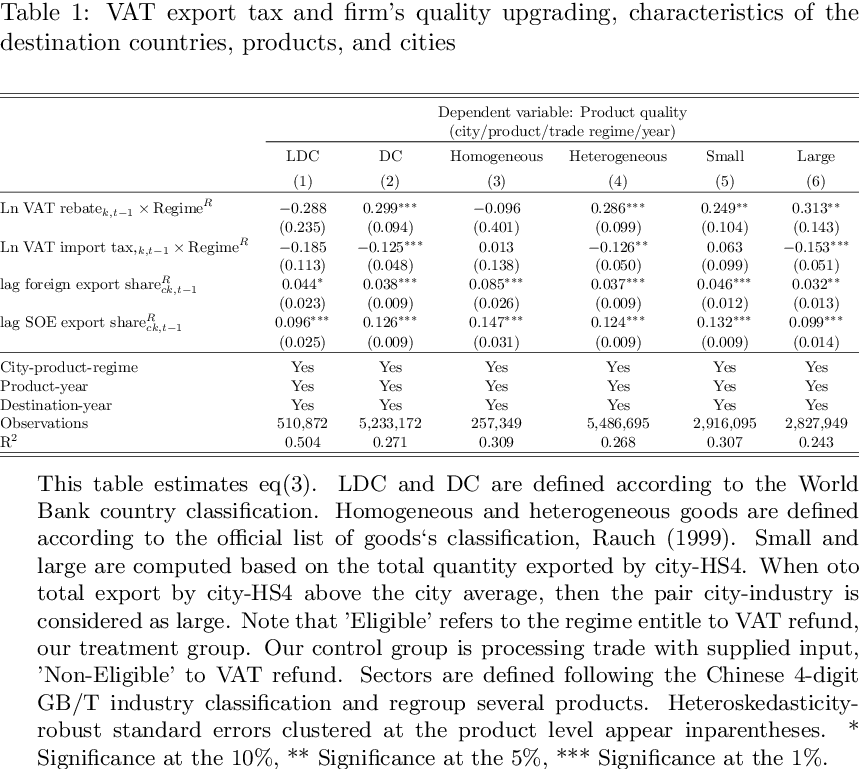

In [122]:
tbe1  = """
This table estimates eq(3). 
LDC and DC are defined according to the World Bank country classification.
Homogeneous and heterogeneous goods are defined according to the official list of goods`s classification, Rauch (1999).
Small and large are computed based on the total quantity exported by city-HS4.
When oto total export by city-HS4 above the city average, then the pair city-industry is considered as large.
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'LDC': 1,
    'DC': 1,
    'Homogeneous': 1,
    'Heterogeneous': 1,
    'Small': 1,
    'Large': 1
}
multi_lines_dep = '(city/product/trade regime/year)'
reorder = {
    2:0,
    3:1
}
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
           folder = folder)

## Table 3: Industry characteristicts

* Column 1 excludes rare earth products with the main fixed effect:
* Column 2 excludes energy intensive industries with the main fixed effect:
* Column 3 excludes high tech industries with the main fixed effect:
* Column 4 excludes RD oriented indusrtries with the main fixed effect:
* Column 5 excludes High skilled oriented with the main fixed effect:
  
Sector is defined as the GBT 4 digits

In [ ]:
db = 'environment'
query = """
WITH temp AS (
SELECT ind2, SUM(tso2) as sum_tso2
FROM environment.china_city_sector_pollution  
WHERE year = '2002'
GROUP BY ind2
ORDER BY sum_tso2
  )
  SELECT *
  FROM temp
  LEFT JOIN (
    SELECT cic as ind2, short
    FROM chinese_lookup.ind_cic_2_name
    ) as ind_name
    ON temp.ind2 = ind_name.ind2
"""
list_polluted = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='polluted',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_polluted

In [ ]:
(
    list_polluted.loc[lambda x: x['sum_tso2'] >=np.quantile(list_polluted['sum_tso2'], 0.75)]
    .reindex(columns = ['ind2', 'short'])
)

In [ ]:
folder = 'Tables_0'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
to_remove <- c(
  "13",
"17",
"22",
"25",
"33",
"26",
"32",
"31"
)
#### RARE HEARTH
t_0 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(hs6 != 850511),
            exactDOF = TRUE)
t_0 <- change_target(t_0)
print('table 0 done')

#### NO LARGE POLLUTED INDUSTRY
t_1 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(!(hs2 %in% to_remove)),
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')

#### HIGH TECH
t_2 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(high_tech)),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')
#### SKILLED
t_3 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(skilled)),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 3 done')
##### RD
t_4 <- felm(kandhelwal_quality ~ln_rebate_1* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(rd_oriented)),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 4 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
%get path table
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'No rare-earth': 1,
    'No polluted intensive': 1,
    'No high tech': 1,
    'No RD oriented': 1,
    'No high skilled oriented': 1,
}
reorder = {
    2:0,
    3:1
}
multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc

In [ ]:
name_json = 'parameters_ETL_VAT_rebate_quality_china.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = True, notebookname = "00_baseline_vat_quality.ipynb")

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)